In [1]:
# Importing all the necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
%matplotlib inline

In [2]:
# Importing the data and looking at the first ten rows

df = pd.read_csv('/kaggle/input/credit-card-customers/BankChurners.csv')

df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


In [3]:
# Dropping the last two columns and the client number column

df = df.iloc[:,1:-2]

In [4]:
# Checking the Descriptive statistics of the numerical columns

df.describe().T

,count,mean,std,min,25%,50%,75%,max
Customer_Age,10127.0,46.325960,8.016814,26.0,41.000,46.000,52.000,73.000
Dependent_count,10127.0,2.346203,1.298908,0.0,1.000,2.000,3.000,5.000
Months_on_book,10127.0,35.928409,7.986416,13.0,31.000,36.000,40.000,56.000
Total_Relationship_Count,10127.0,3.812580,1.554408,1.0,3.000,4.000,5.000,6.000
Months_Inactive_12_mon,10127.0,2.341167,1.010622,0.0,2.000,2.000,3.000,6.000
Contacts_Count_12_mon,10127.0,2.455317,1.106225,0.0,2.000,2.000,3.000,6.000
Credit_Limit,10127.0,8631.953698,9088.776650,1438.3,2555.000,4549.000,11067.500,34516.000
Total_Revolving_Bal,10127.0,1162.814061,814.987335,0.0,359.000,1276.000,1784.000,2517.000
Avg_Open_To_Buy,10127.0,7469.139637,9090.685324,3.0,1324.500,3474.000,9859.000,34516.000
Total_Amt_Chng_Q4_Q1,10127.0,0.759941,0.219207,0.0,0.631,0.736,0.859,3.397


In [5]:
# Changing the Attrition_Flag to 0 and 1

df["Attrition_Flag"] = df["Attrition_Flag"].map({"Existing Customer":0, "Attrited Customer":1})

In [6]:
# Creating the dummy variables for all the categorical features

cat_cols = list(df.select_dtypes("object"))

for col in cat_cols:
    dummy_cols = pd.get_dummies(df[col], drop_first=True, prefix=col)
    df = pd.concat([df,dummy_cols],axis=1)
    df.drop(columns=col, inplace=True)

In [7]:
# Splitting the data into train and test

X = df.drop("Attrition_Flag", axis=1)
y = df["Attrition_Flag"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [8]:
from sklearn.pipeline import Pipeline

# Normalizing and standardizing the data
req_cols = ['Customer_Age', 'Dependent_count', 'Months_on_book', 'Total_Relationship_Count',
            'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
            'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1',
            'Avg_Utilization_Ratio']

pipeline = Pipeline([
    ('minmax', MinMaxScaler()),
    ('standard', StandardScaler())
])

X_train = pipeline.fit_transform(X_train[req_cols])
X_test = pipeline.transform(X_test[req_cols])

In [10]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import SGDClassifier, RidgeClassifier
from keras.models import Model, Sequential
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

classifiers = {
    "Logistic Regression": LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    "Ridge Classifier": RidgeClassifier(random_state=42, class_weight='balanced'),
    "SGD Classifier": SGDClassifier(loss='log_loss', max_iter=1000, random_state=42, class_weight='balanced'),
    "SVM": SVC(kernel="rbf", C=10, probability=True, random_state=42, class_weight='balanced'),
    "CatBoost": CatBoostClassifier(iterations=100, random_seed=42, eval_metric='Logloss', auto_class_weights='Balanced', verbose=0 ),
    "XGBoost": XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric="logloss", random_state=42, class_weight='balanced')
}

In [11]:
for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    print("Classifiers: ", classifier.__class__.__name__, "has a score of", round(score.mean(), 2) * 100, "% accuracy score")
    print("Classification Report: \n", classification_report(y_test, y_pred))
    print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred), "\n")

Classifiers:  LogisticRegression has a score of 85.0 % accuracy score
Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.86      0.91      1701
           1       0.52      0.81      0.63       325

    accuracy                           0.85      2026
   macro avg       0.74      0.83      0.77      2026
weighted avg       0.89      0.85      0.86      2026

Confusion Matrix: 
 [[1461  240]
 [  63  262]] 

Classifiers:  RandomForestClassifier has a score of 95.0 % accuracy score
Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.99      0.97      1701
           1       0.93      0.77      0.84       325

    accuracy                           0.95      2026
   macro avg       0.94      0.88      0.91      2026
weighted avg       0.95      0.95      0.95      2026

Confusion Matrix: 
 [[1683   18]
 [  76  249]] 

Classifiers:  RidgeClassifier has a score of 84.0 % ac

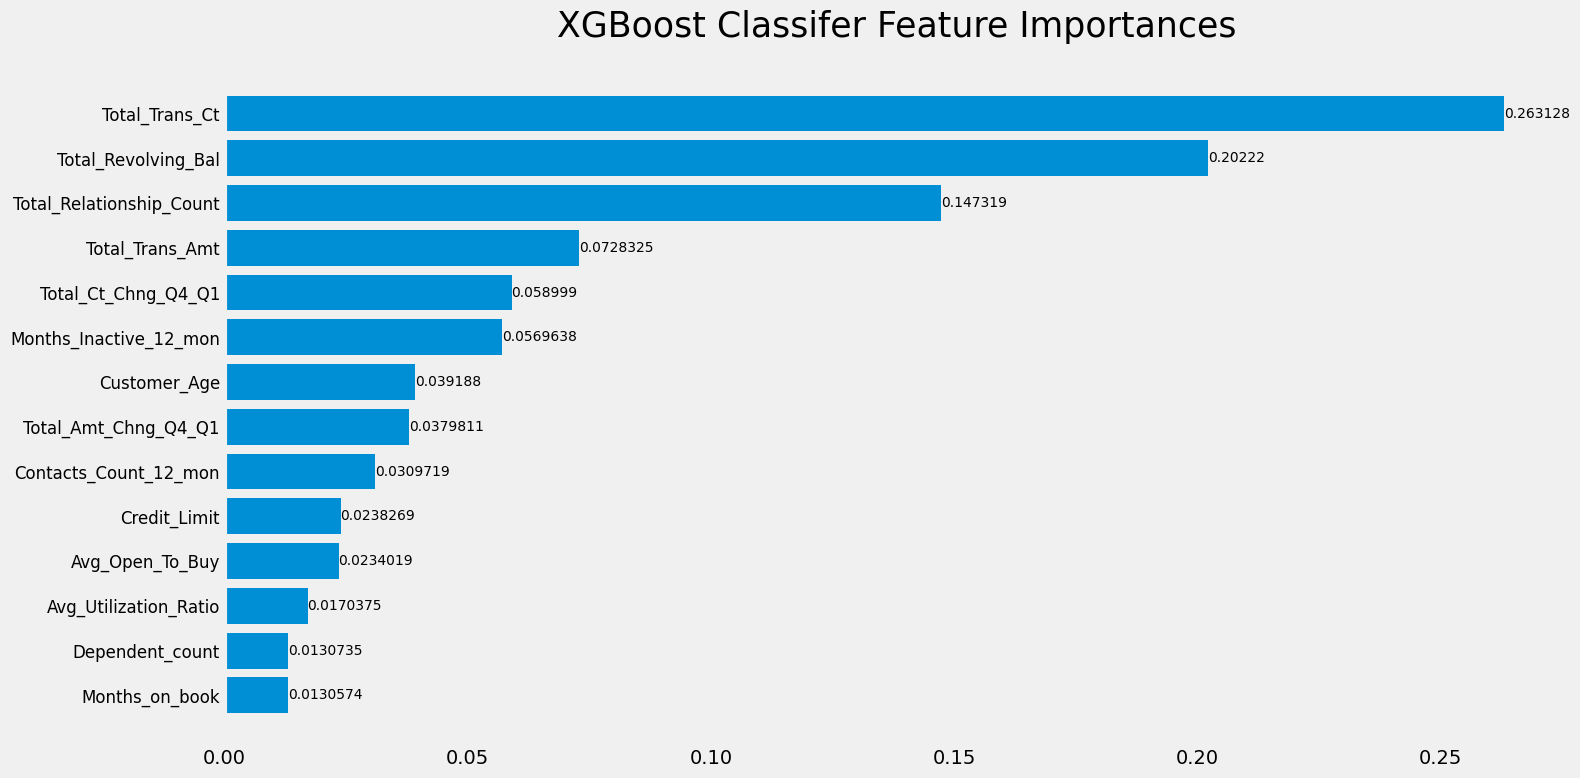

In [12]:
# Plotting the important features (Hidden Input)

features_to_plot = len(req_cols)

importances = classifier.feature_importances_
indices = np.argsort(importances)

best_vars = np.array(req_cols)[indices][-features_to_plot:]
values = importances[indices][-features_to_plot:]
best_vars

y_ticks = np.arange(0, features_to_plot)
fig, ax = plt.subplots(figsize=(16,8))
ax.barh(y_ticks, values)
ax.set_yticklabels(best_vars, size=12)
ax.set_yticks(y_ticks)
ax.set_title("XGBoost Classifer Feature Importances", size=25, pad=20, color='black')
ax.bar_label(ax.containers[0], size="10")
fig.tight_layout()
plt.grid(False)
plt.savefig("Feature_Importance_XGBoost.png", dpi=1200)
plt.show()